# Predicting median housing prices in California
In this project I will analyse some housing pricing data from California and try to train a model that predicts the median price of housing in a specific block group based on some given variables.
The project is explained and treated in more detail in the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurelien Geron ([link to book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)).

## Getting the data
The dataset is the California Housing Prices dataset from the StatLib
repository, which is based on data from the 1990 California census. The data is comprised of diffrent metrics for block groups (we'll refer to them as districts) in California.

In [32]:
import os
import tarfile
import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


# Function that gets the data and puts it in a directory /datasets/housing

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [33]:
fetch_housing_data()

In [34]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [35]:
housing = load_housing_data()

## Data exploration
In this section we will gain some insight on what data we are working with

In [36]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [37]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We notice that `total_bedrooms` has some missing values, we will deal with that later

They're also all numereical values except for `ocean_proximity` which appears to be categorical:

In [38]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [39]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


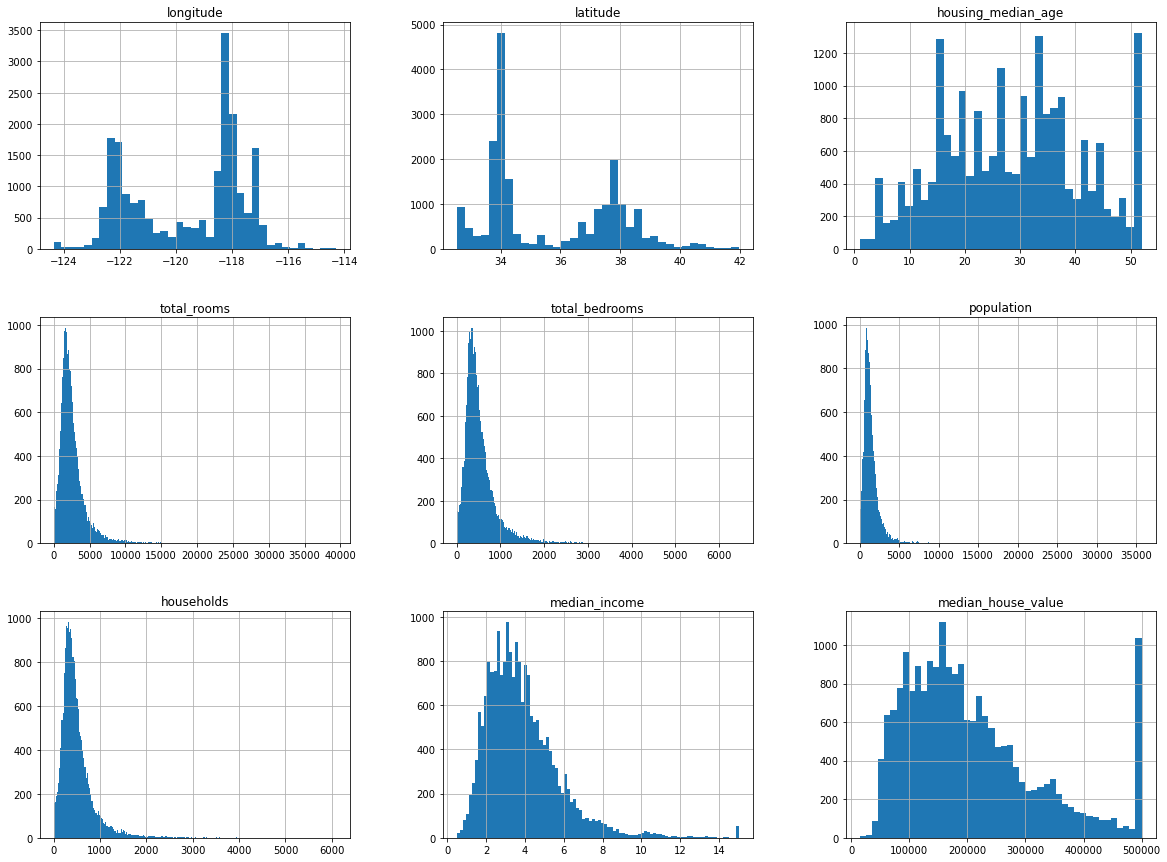

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins="auto", figsize=(20, 15))
plt.show()

`housing_median_age`, `median_house_value` and `median_income` are all capped (at 52, 500001 and 15 respectively), and the median income appears to be not in $ but tens of thousands of \\$.

The `median_house_value` cap might be a problem since that is our target attribute and the machine learning algorithms might learn that prices never go beyond $500k, so we can: 

* label the districts appropriately
* or eliminate those districts (so the model is not evalueted poorly if it predicts values beyond \$500k).

The attributes have very different scales, and many are right skewed, so they might need to be transformed.

## Splitting data into train and test sets
Before looking at the data any further, we should set aside a test set and never look at it so that we won't be biased in the selection of a specific model, in case that we notice a pattern in the set. When it comes to estimating a generalisation error using the test set we might have an overly optimistic estimation and launch a sistem that will not perform as well as expected.

To have a stable testing set, we can compute a hash for each instance using its unique identifier, and add it to the testing set if the hash is lower thatn or equal to 20% of the maximum hash value (in the case of an 80/20 split), so the testing set won't have any instance that was previously in the training set, if the splitting function were to be run again (in the case of updating the dataset). Unfortunately our dataset doesn't have a unique id, so we will use the row index as the ID.

In [41]:
import numpy as np
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [42]:
# Adding an index column
housing_with_id = housing.reset_index()

If we use the index as an ID we will need to make sure that any new rows are added at the end of the table, and that no row gets deleted. So instead we can tie the index to a constant value, like latitude and longitude, to create a stable unique ID.

In [43]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Generally it is fine to split the data with random sampling, but if the dataset is small, like in this case, we might introduce a sampling bias. To avoid this we can perform stratified sampling by splitting the median income (which in this case is a good predictor of the median house value) into categories, and then try to keep the proportion of these categories when splitting the data.

In [44]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

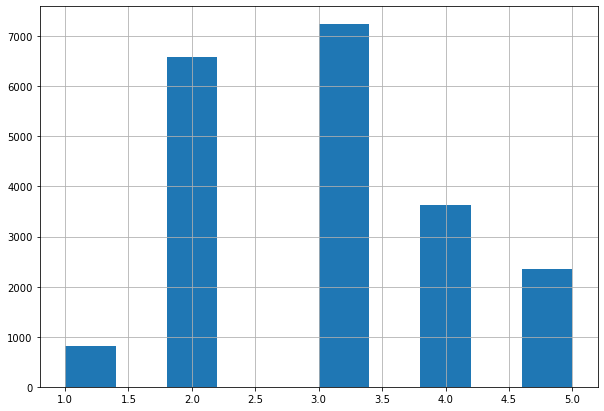

In [45]:
housing["income_cat"].hist(figsize=(10,7))

Splitting the data while preserving the proportion of each income category:


In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [47]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [48]:
# Removing the income_cat column to bring the data back to normal
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.copy()

We are done splitting the data and we can move on to the next stages of data exploration.


### Visualising geographical data

Plotting the density of districts using their coordinates to see how they distribute:


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

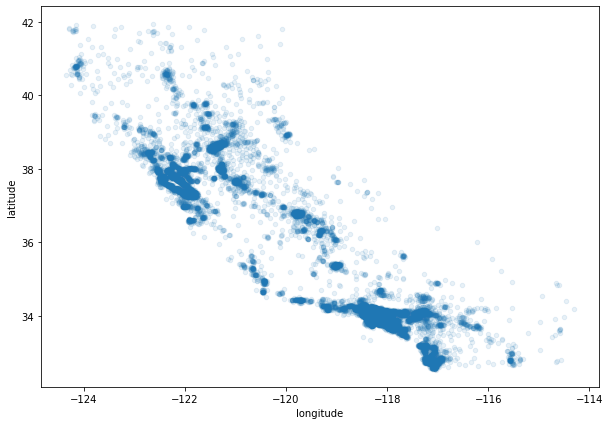

In [49]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10,7))

Plotting the district density along with the mean house value, and we can see that houses tend to be more expensive towards the coast and in the main cities:


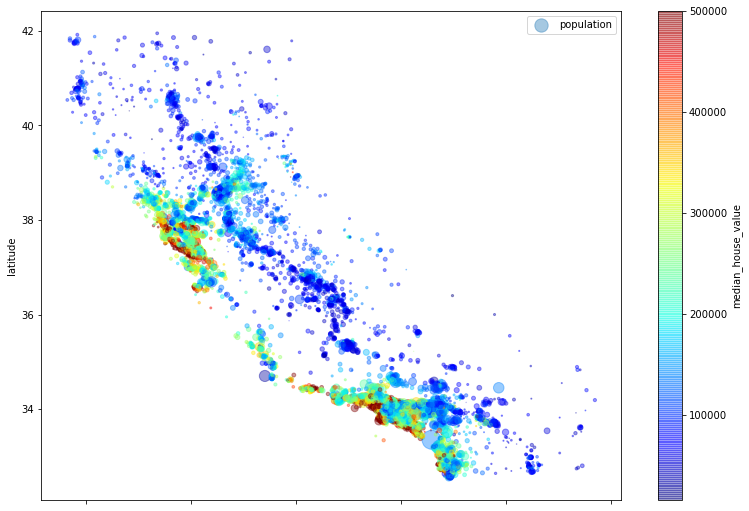

In [50]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(13,9),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

Seeing which attribute is most correlated with the median house value by
computing the standard correlation coefficient:

In [51]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Plotting some attributes against each other using `scatter_matrix()` 
to see how correlated they are, and it seems that `median_income`
is the best (linear) indicator of the `median_house_value`

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

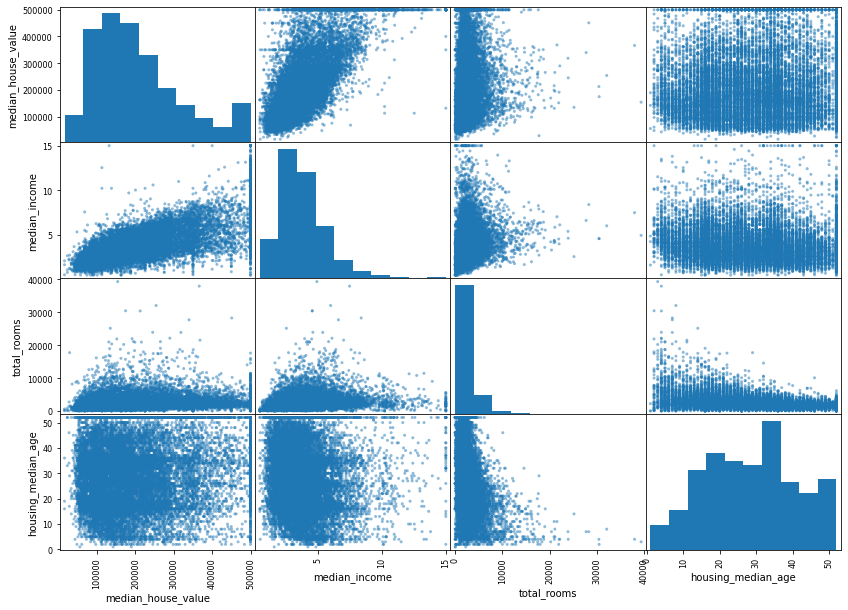

In [52]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(14,10))

If we plot `median_house_value` and `median_income` separately 
we can see a line wherethe cap at 500k is and a few more below that, 
ideally thew should be removed

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

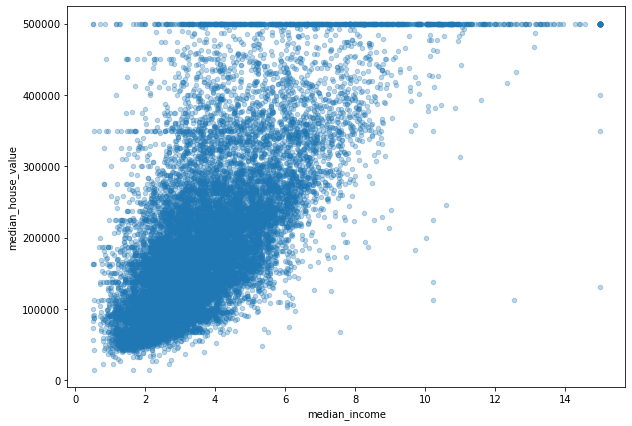

In [53]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", 
             alpha=0.3, figsize=(10, 7))

Trying out some extra attributes that are more descriptive like rooms per household, bedrooms per room and population per household to see if they're better indicators of the `median_house_value`


In [54]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

We compute the standard correlation coefficient, and we can see that 
`bedrooms_per_room` is much more correlated to `median_house_value` than `total_bedrooms` or `total_rooms`:

In [56]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Data cleaning and processing

In [65]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

We need to fill all the missing values with the median of the attributes, we ill use 
sklearn's `SimpleImputer`:

In [66]:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1) # All the numerical attributes

# We apply the imputer to all the numerical attributes just 
# to make sure that there are to missing values
imputer.fit(housing_num) 

SimpleImputer(strategy='median')

In [67]:
imputer.statistics_ # The computed medians of the numerical attributes

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [68]:
z = imputer.transform(housing_num)

In [69]:
housing_tr = pd.DataFrame(z, columns=housing_num.columns, index=housing_num.index)

In [70]:
housing_oc = housing[["ocean_proximity"]]

### Handling categorical attributes (ocean_proximity)
We will use one-hot encoding to convert `ocean_proximity` to a numerical attribute

In [71]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
housing_oc_1hot = enc.fit_transform(housing_oc)

This is a custom transformer that adds the combined attributes that we created earlier:

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, z, y=None):
        return self
    def transform(self, z, y=None):
        rooms_per_household = z[:, rooms_ix]/z[:, households_ix]
        population_per_household = z[:, population_ix]/z[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = z[:, bedrooms_ix]/z[:, rooms_ix]
            return np.c_[z, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[z, rooms_per_household, population_per_household]
        

Now we'll build a pipeline that performs a series fo transformations on the numerical data, and then on both numerical and categorical data:

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('att_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])

num_att = list(housing_num)
cat_att = ["ocean_proximity"]

pipeline_all = ColumnTransformer([('num', num_pipeline, num_att), 
                                  ('cat', OneHotEncoder(), cat_att)
                                 ])

housing_done = pipeline_all.fit_transform(housing)

## Finding an appropriate model
Now finally after understanding the problem, looking at the data, cleaning and preparing it we can start looking for a model.

We'll start with a linear regression model:

### Linear regression

In [74]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_done, housing_labels)

LinearRegression()

Seeing how it performs on a few instances:

In [75]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_done = pipeline_all.transform(some_data)
lin_reg_predictions = lin_reg.predict(some_data_done)
print("Predictions: ", lin_reg_predictions)
print("Labels: ", list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


The predictions don't seem very accurate, so we'll now calculate the mean squared error:

In [76]:
from sklearn.metrics import mean_squared_error

lr_housing_predictions = lin_reg.predict(housing_done)
lin_reg_mse = mean_squared_error(housing_labels, lr_housing_predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)

In [77]:
lin_reg_rmse

68628.19819848923

We'll use K-fold cross-validation to see a more accurate evaluation:

In [78]:
from sklearn.model_selection import cross_val_score

lr_scores = cross_val_score(lin_reg, housing_done, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)
lr_rmse_scores = np.sqrt(-lr_scores)


def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("St Dev: ", scores.std())

display_scores(lr_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
St Dev:  2731.674001798348


\$68k doesn't seem very promising so we'll try another model. 

### Decision Tree Regressor

In [79]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor()
dec_tree.fit(housing_done, housing_labels)

DecisionTreeRegressor()

In [80]:
dt_housing_predictions = dec_tree.predict(housing_done)
dec_tree_mse = mean_squared_error(housing_labels, dt_housing_predictions)
dec_tree_rmse = np.sqrt(dec_tree_mse)
dec_tree_rmse

0.0

Well the error is 0 so the decision tree clearly overfit the data. We will check now with cross-validation.

In [121]:
scores = cross_val_score(dec_tree, housing_done, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
dt_rmse_scores = np.sqrt(-scores)

In [122]:
display_scores(dt_rmse_scores)

Scores:  [67669.73816437 67362.61970456 70229.34328631 68299.62160307
 71291.36213287 75577.59634532 72668.53981039 70226.23940832
 77010.86953522 69438.29976359]
Mean:  70977.42297540254
St Dev:  3085.3445235048844


Now it seems that it is worse than the linear regression model, so we'll move on to another model, random forest regressor.

### Random Forest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor

r_forest = RandomForestRegressor()
r_forest.fit(housing_done, housing_labels)

RandomForestRegressor()

In [82]:
rf_scores = cross_val_score(r_forest, housing_done, housing_labels, 
                           scoring="neg_mean_squared_error", cv=10)

rf_rmse_scores = np.sqrt(-rf_scores)

In [83]:
display_scores(rf_rmse_scores)

Scores:  [49531.71459488 47442.13062727 50003.75579206 52515.54160387
 49806.55933906 53536.3392834  48599.99432444 48339.11275179
 53021.11685218 49961.37889293]
Mean:  50275.76440618836
St Dev:  1967.7348988649394


In [84]:
rf_predictions = r_forest.predict(housing_done)
rf_mse = mean_squared_error(housing_labels, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

18713.85887323378

This seems much better than the previous models so we'll keep an eye on it. Next we'll try a support vector machine model with different kernels.

### SVM with different kernels

In [139]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(housing_done, housing_labels)

SVR()

In [141]:
svr_predictions = svr.predict(housing_done)
svr_mse = mean_squared_error(housing_labels, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118580.68301157995

In [142]:
svr_scores = cross_val_score(svr, housing_done, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

In [143]:
display_scores(svr_rmse_scores)

Scores:  [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
Mean:  118572.66762937943
St Dev:  2936.8775867949425


SVR with the default kernel doesn't seem to perform well...

In [146]:
svr_poly = SVR(kernel="poly")
svr_poly.fit(housing_done, housing_labels)

SVR(kernel='poly')

In [148]:
svrp_predictions = svr_poly.predict(housing_done)
svrp_mse = mean_squared_error(housing_labels, svrp_predictions)
svrp_rmse = np.sqrt(svrp_mse)
svrp_rmse

118428.30364148875

In [149]:
svr_lin = SVR(kernel="linear")
svr_lin.fit(housing_done, housing_labels)

SVR(kernel='linear')

In [150]:
svr_lin_predictions = svr_lin.predict(housing_done)
svr_lin_mse = mean_squared_error(housing_labels, svr_lin_predictions)
svr_lin_rmse = np.sqrt(svr_lin_mse)
svr_lin_rmse

111094.6308539982

In [151]:
svr_lin_scores = cross_val_score(svr_lin, housing_done, housing_labels, 
                            scoring="neg_mean_squared_error", cv=10)
svr_lin_rmse_scores = np.sqrt(-svr_lin_scores)

In [152]:
display_scores(svr_lin_rmse_scores)

Scores:  [105342.09141998 112489.24624123 110092.35042753 113403.22892482
 110638.90119657 115675.8320024  110703.56887243 114476.89008206
 113756.17971227 111520.1120808 ]
Mean:  111809.84009600841
St Dev:  2762.393664321567


After trying polynomial and linear kernels we still got bad results so it's not an appropreate model. Up next we'll try a neural network.

### Multiple Layer Perceptron Regressor

In [85]:
from sklearn.neural_network import MLPRegressor

mlpr = MLPRegressor(random_state=1, max_iter=500)
mlpr.fit(housing_done, housing_labels)

/home/huginn/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(max_iter=500, random_state=1)

In [86]:
mlpr_predictions = mlpr.predict(housing_done)
mlpr_mse = mean_squared_error(housing_labels, mlpr_predictions)
mlpr_rmse = np.sqrt(mlpr_mse)
mlpr_rmse

75612.90259772424

The NN doesn't seem to find a convergence point and the RMSE score is not great anyway so we won't perform the cross-validation since it's time consuming and resource intensive.

So far the Random Forest Regressor seems to be the best performing model so we'll move on to hyperparameter tuning.

## Fine-tuning
Using `GridSearchCV` we'll try different values for `n_estimators` and `max_features`, and then with `bootstrap` set to `False`, to see what combination of parameters performs best.

In [158]:
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_estimators": [3, 7, 15, 35, 50], "max_features": [2, 4, 6, 8, 10]}, 
              {"bootstrap": [False], "n_estimators": [3, 7], "max_features": [2, 3, 4]}]

rf_regressor = RandomForestRegressor()
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring="neg_mean_squared_error", 
                          return_train_score=True)
grid_search.fit(housing_done, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [3, 7, 15, 35, 50]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 7]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [160]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=50)

We access the best combinatioin of parameters and we see that they're 6 for `max_features` and 50 for `n_estimators` which was the highest value so we'll try higher values to see if it performs better incase it was capped at theat limit:

In [161]:
param_grid2 = [{"n_estimators": [55, 70, 100], "max_features": [5, 7]}, 
               {"bootstrap": [False], "n_estimators": [55, 60, 85], "max_features": [5, 7]}]

grid_search = GridSearchCV(rf_regressor, param_grid2, cv=5, scoring="neg_mean_squared_error", 
                          return_train_score=True)
grid_search.fit(housing_done, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [5, 7],
                          'n_estimators': [55, 70, 100]},
                         {'bootstrap': [False], 'max_features': [5, 7],
                          'n_estimators': [55, 60, 85]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [162]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=85)

We pinpointed the `max_features`, discovered that `False` for `bootstrap` works better but `n_estimators` still reached the limit it seems so we'll try higher values:

In [163]:
param_grid3 = [{"bootstrap": [False], "n_estimators": [85, 100, 150, 200], 
                "max_features": [5]}]

grid_search = GridSearchCV(rf_regressor, param_grid3, cv=5, scoring="neg_mean_squared_error", 
                          return_train_score=True)
grid_search.fit(housing_done, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [5],
                          'n_estimators': [85, 100, 150, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [164]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=200)

In [165]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

48633.157842415676 {'bootstrap': False, 'max_features': 5, 'n_estimators': 85}
48688.92748625208 {'bootstrap': False, 'max_features': 5, 'n_estimators': 100}
48503.00311724151 {'bootstrap': False, 'max_features': 5, 'n_estimators': 150}
48295.089902174135 {'bootstrap': False, 'max_features': 5, 'n_estimators': 200}


In [166]:
rf_regressor2 = RandomForestRegressor()
param_grid4 = [{"bootstrap": [False], "n_estimators": [250, 300, 350, 400], 
                "max_features": [5]}]

grid_search = GridSearchCV(rf_regressor2, param_grid4, cv=5, scoring="neg_mean_squared_error", 
                          return_train_score=True)
grid_search.fit(housing_done, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [5],
                          'n_estimators': [250, 300, 350, 400]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [167]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=300)

After reaching the upper value a few times we finally found the optimal value for `n_estimators` at 300, and now we'll print the scores:

In [168]:
cv_res2 = grid_search.cv_results_
for mean_score, params in zip(cv_res2["mean_test_score"], cv_res2["params"]):
    print(np.sqrt(-mean_score), params)

48333.286801407594 {'bootstrap': False, 'max_features': 5, 'n_estimators': 250}
48180.01249299697 {'bootstrap': False, 'max_features': 5, 'n_estimators': 300}
48262.36529403967 {'bootstrap': False, 'max_features': 5, 'n_estimators': 350}
48268.62660605544 {'bootstrap': False, 'max_features': 5, 'n_estimators': 400}


Now we can finally evaluate it on the test set: 

In [169]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_done = pipeline_all.transform(X_test)

final_pred = final_model.predict(X_test_done)

final_model_mse = mean_squared_error(y_test, final_pred)
final_model_rmse = np.sqrt(final_model_mse)
final_model_rmse

46108.78988742551

Our final model seems to have a RMSE of \$46k which is better than the initial \\$53k.
Now to make sure that the generalisation error estimate is accurate we can compute a 95% confidence interval for it using `scipy.stats.t.interval`:

In [170]:
from scipy import stats

confidence = 0.95
sq_errors = (final_pred - y_test) ** 2

conf_interval = np.sqrt(stats.t.interval(confidence, (len(sq_errors)-1), 
                       loc=sq_errors.mean(), scale=stats.sem(sq_errors)))
conf_interval

array([44124.37983071, 48011.24987251])

# Summary
In this project I learned a good amount of techniques and tools to use from the sklearn library and gained a better understanding of supervised regression models.
We analysed the data and we concluded that the median income is the best predictor of housing values, we spilt the data in a way to make it consistent and then we performed stratified sampling to prevent a biased evaluation, which is an important aspect nowdays especially when machine learning models are becoming more responsible for decisions that affect people. 
We processed the data using a custom transformer, dealt with non-numerical data and built pipelines to automate the process of data transformation.
Then finally practiced K-fold cross-validation, trained different models to see their performance and automated hyperparameter tuning using `GridSearchCV`. 
The final model wasn't necessarily very accurate but it can be used in conjunction with other ways of predicting and still save some time.